In [3]:
import torch
import os
import numpy as np
from torch import optim
from torch.utils.data import DataLoader
from torchmetrics.functional.text import bleu_score
from transformers import T5Tokenizer, T5ForConditionalGeneration
import lightning.pytorch as pl
from datasets import load_dataset

In [4]:
class Seq2Seq(pl.LightningModule):
    def __init__(self, model_name_or_path):
        super().__init__()
        self.save_hyperparameters()
        
        self.model = T5ForConditionalGeneration.from_pretrained(model_name_or_path)
        self.tokenizer = T5Tokenizer.from_pretrained(model_name_or_path)

    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        
        loss = self.model(input_ids=batch["input_ids"], labels=batch["labels"]).loss
        self.log("train_loss", loss.detach().cpu().item(), prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        val_loss = self.model(input_ids=batch["input_ids"], labels=batch["labels"]).loss
        self.log("val_loss", val_loss.detach().cpu().item(), prog_bar=True)
        return val_loss

    def predict_step(self, batch, batch_idx):
        outputs = self.model.generate(input_ids=batch["input_ids"])

        preds = []
        for i in range(len(outputs)):
            pred = self.tokenizer.decode(outputs[i], skip_special_tokens=True)
            preds.append(pred)
        preds = np.array(preds) 
        
        return preds
    
    def test_step(self, batch, batch_idx):
        outputs = self.model.generate(batch["input_ids"])
        
        preds = []
        for i in range(len(outputs)):
            pred = self.tokenizer.decode(outputs[i], skip_special_tokens=True)
            preds.append(pred)
        preds = np.array(preds)
        
        bleu = bleu_score(preds, batch["summaries"])
        self.log("bleu", bleu.detach().cpu().item(), prog_bar=True)
        return bleu
        
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=2e-5)
        return optimizer

In [5]:
class Seq2SeqDataModule(pl.LightningDataModule):
    def __init__(self, model_name_or_path, ds_name, subset_name=None):
        super().__init__()
        self.tokenizer = T5Tokenizer.from_pretrained(model_name_or_path)
        self.ds_name = ds_name
        self.subset_name = subset_name
    
    def prepare_data(self):
        if self.subset_name:
            self.ds = load_dataset(self.ds_name, name=self.subset_name)
        else:
            self.ds = load_dataset(self.ds_name)
        
    def train_dataloader(self):
        train_split = self.ds["train"]
        return DataLoader(train_split, batch_size=1, collate_fn=self.collate, num_workers=os.cpu_count())
    
    def val_dataloader(self):
        val_split = self.ds["validation"]
        return DataLoader(val_split, batch_size=1, collate_fn=self.collate, num_workers=os.cpu_count())
    
    def predict_dataloader(self):
        test_split = self.ds["test"]
        return DataLoader(test_split, batch_size=64, collate_fn=self.collate_test, num_workers=os.cpu_count())
    
    def test_dataloader(self):
        test_split = self.ds["test"]
        return DataLoader(test_split, batch_size=64, collate_fn=self.collate_test, num_workers=os.cpu_count())
    
    def tokenize(self, row):
        row["input_ids"] = self.tokenizer(f'summarize: {row["source"]}', max_length=512, padding='max_length', truncation=True, return_tensors="pt").input_ids.squeeze()
        row["labels"] = self.tokenizer(row["target"], max_length=512, padding='max_length', truncation=True, return_tensors="pt").input_ids.squeeze()
        return row
    
    def collate(self, samples):
        input_ids = torch.stack([self.tokenizer(f'summarize: {s["source"]}', max_length=512, padding='max_length', truncation=True, return_tensors="pt").input_ids.squeeze() for s in samples])
        labels = torch.stack([self.tokenizer(s["target"], max_length=512, padding='max_length', truncation=True, return_tensors="pt").input_ids.squeeze() for s in samples])
        
        return {"input_ids": input_ids, "labels": labels}
    
    def collate_test(self, samples):
        summaries = np.stack([np.array(s["target"]) for s in samples])
        input_ids = torch.stack([self.tokenizer(f'summarize: {s["source"]}', max_length=512, padding='max_length', truncation=True, return_tensors="pt").input_ids.squeeze() for s in samples])
        
        return {"input_ids": input_ids, "summaries": summaries}
        

In [6]:
seq2seq_dm = Seq2SeqDataModule("cointegrated/rut5-base-absum", "GEM/wiki_lingua", 'ru')

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [7]:
seq2seq_model = Seq2Seq("cointegrated/rut5-base-absum")

In [17]:
# logger = TensorBoardLogger('tb_logs', name='my_model')
trainer = pl.Trainer(max_epochs=15)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [9]:
trainer.predict(model=seq2seq_model, datamodule=seq2seq_dm)

Missing logger folder: /home/ext-shirokov-m@ad.speechpro.com/shirokov/NLP/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

/home/ext-shirokov-m@ad.speechpro.com/miniconda3/envs/nlp/lib/python3.11/site-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[array(['Создайте медленноварку. Создайте Ice Box. Создайте Ice Box',
        'Добавьте клейкий рис. Добавьте клейкий рис. Добавьте',
        'Установите хомут. Установите хомут. Установите хомут.',
        'Определите симптомы среднего отита. Обращайтесь к врачу. Обраща',
        'Чистите камин. Чистите камин. Чистите камин.',
        'Установите программу 4K Video Downloader. Установите программу 4K Video',
        'Создайте подвижный источник воды. Начните распылить воду в',
        'Создайте новый документ. Щелкните по значку программы Word. Щелкните',
        'Выберите воду комнатной температуры. Принимайте ибупрофен.',
        'Определите годовой рост своего дохода. Определите годовой рост своего',
        'Вскипятите молоко. Нагрейте жидкое молоко. Нагрейте',
        'Определите возможности вашего подопечного к чтению. Определите возможности',
        'Выберите хорошую сцену. Выберите одну хорошую сцену.',
        'Определите, что у вас есть хронический гастрит. Посоветуйтесь с 

In [10]:
trainer.test(model=seq2seq_model, datamodule=seq2seq_dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

/home/ext-shirokov-m@ad.speechpro.com/miniconda3/envs/nlp/lib/python3.11/site-packages/lightning/pytorch/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 64. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
/home/ext-shirokov-m@ad.speechpro.com/miniconda3/envs/nlp/lib/python3.11/site-packages/lightning/pytorch/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 42. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           bleu            │   0.0012569796526804566   │
└───────────────────────────┴───────────────────────────┘

[{'bleu': 0.0012569796526804566}]

In [18]:
trainer.fit(model=seq2seq_model, datamodule=seq2seq_dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 244 M 
-----------------------------------------------------
244 M     Trainable params
0         Non-trainable params
244 M     Total params
977.237   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


In [19]:
trainer.test(model=seq2seq_model, datamodule=seq2seq_dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

/home/ext-shirokov-m@ad.speechpro.com/miniconda3/envs/nlp/lib/python3.11/site-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           bleu            │    0.0054322206415236     │
└───────────────────────────┴───────────────────────────┘

[{'bleu': 0.0054322206415236}]

In [20]:
trainer.predict(model=seq2seq_model, datamodule=seq2seq_dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

[array(['Если вы еще не добыли, то вам нужно будет добыть',
        'Добавьте в кастрюлю рис и приправу. Доведите воду',
        'Проверьте металл на режущей стороне. Установите хомут на лез',
        'Обращайте внимание на симптомы. Обращайте внимание на симптомы простуды',
        'Подготовьте все необходимое. Выньте из камина остатки мусора.',
        'Скачайте программу 4K Video Downloader. Установите программу 4K Video',
        'Найдите подвижный источник воды. Распылите воду в воздухе.',
        'Откройте документ Microsoft Word. Откройте меню Файл. Нажмите',
        'Принимайте отпускаемые без рецепта обезболивающие средства. Прикладывайте к лун',
        'Определите годовой рост своего дохода. Вычтите исходный доход от',
        'Вскипятите воду. Нагрейте молоко. Закипятите молоко',
        'Поймите, что взрослый может не схватывать новые навыки',
        'Определите, когда начинается рассказ. Выберите завершающую сцену.',
        'Обратитесь к врачу. Сделайте эндоскопию. Прин

In [21]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 454560), started 2 days, 11:56:56 ago. (Use '!kill 454560' to kill it.)

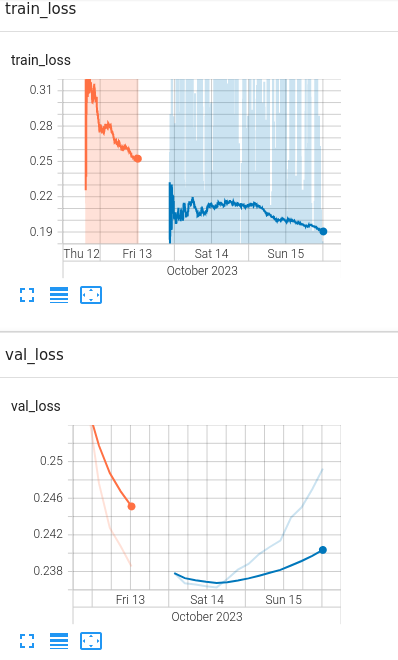